In [4]:
%matplotlib inline

In [5]:
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


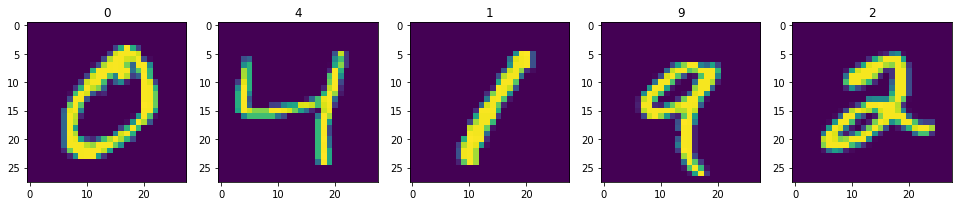


Epoch: 1/2, Train Loss: 0.30743869, Val Loss: 0.05787825, Val Accuracy: 0.98222222
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05787825

Epoch: 2/2, Train Loss: 0.11153473, Val Loss: 0.03991405, Val Accuracy: 0.98711111
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03991405


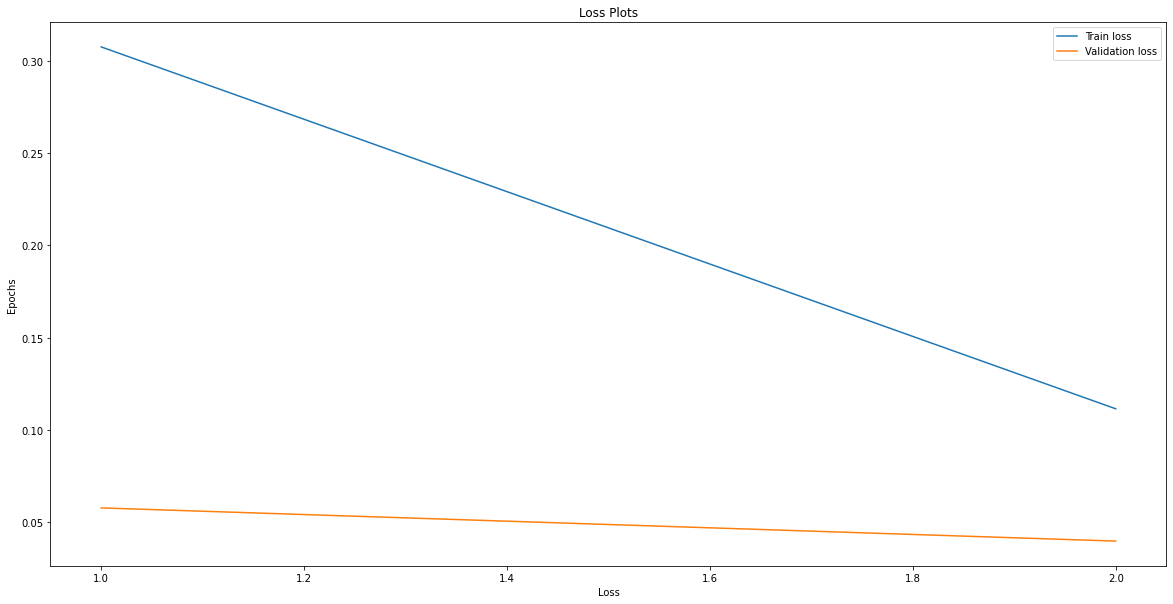

Test accuracy 30.93750000


In [7]:
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np


mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()


model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if (torch.cuda.is_available()):
    model.cuda()

no_epochs = 10
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / (itr + 1)
print('Test accuracy {:.8f}'.format(test_accuracy))

# visualize results (throwing an error so I am commenting this out for now)
# fig=plt.figure(figsize=(20, 10))
# for i in range(1, 11):
#     img = transforms.ToPILImage(mode='L')(results[i][0].squeeze(0).detach().cpu())
#     fig.add_subplot(2, 5, i)
#     plt.title(results[i][1].item())
#     plt.imshow(img)
# plt.show()